problems with LSTM

1. LSTM believes that every district is the same, i.e. a less dense area, Tai Po, would have COVID growth as high as a highly populated area, Sham Shui Po.
2. LSTM does not take into account interconnectivity of districts. Every district is on its own island, and COVID cases do not spread between them.

Problems with our model
1. Does not take into account important factors such as lockdowns in that district (which will significantly lower cases in that district after 1/2 weeks)
2.


# train district x with district with high correlation to x (for all district x i.e. 18 times)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -Uqq ipdb

     |████████████████████████████████| 793 kB 27.6 MB/s 
     |████████████████████████████████| 1.6 MB 60.4 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipython~=7.9.0, but you have ipython 7.34.0 which is incompatible.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import ipdb
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Importing the training data
csv_pds = []
dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31"):
    if file.endswith(".csv"):
        csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Feb1_Mar31/"+file,on_bad_lines="skip"))
        dates.append(file[0:8])

In [ ]:
# Preprocessing of our data
# Since the covid data we obtain from the HK gov website has some minor typo in their district names,
# we use a sequence matcher to match the closest name to the district defined in the districts array
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter)
  iter +=1

In [ ]:
series_count_district ={}
for district in districts:
    series_count_district[district] = []
print(series_count_district)

{'Central & Western': [], 'Eastern': [], 'Islands': [], 'Kowloon City': [], 'Kwai Tsing': [], 'Kwun Tong': [], 'North': [], 'Sai Kung': [], 'Sham Shui Po': [], 'Sha Tin': [], 'Southern': [], 'Tai Po': [], 'Tsuen Wan': [], 'Tuen Mun': [], 'Wan Chai': [], 'Wong Tai Sin': [], 'Yau Tsim Mong': [], 'Yuen Long': []}


In [ ]:
day =0
for pd in csv_pds:
    for district in districts:
          series_count_district[district].append((pd['District'] == district).sum())

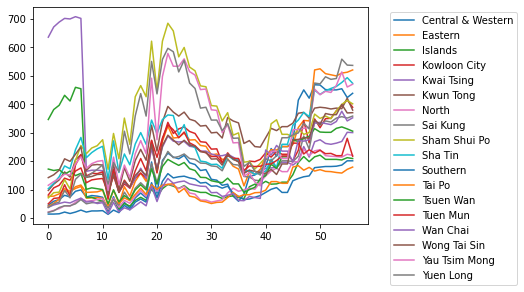

In [ ]:
# Plot the series_count_district data to have an overview 
for district in series_count_district:
    plt.plot(series_count_district[district], label=district)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

In [ ]:
# Creating the pearson correlation matrix
district_series = []
for district in districts:
  district_series.append(series_count_district[district])
correlation = np.corrcoef(district_series, district_series)
useful_correlation = correlation[0:18,0:18]

In [ ]:
connection_threshold = 0.7
adjacency_matrix = np.where(useful_correlation > connection_threshold, 1, 0)

In [ ]:
# N = 100 # number of theoretical series of games
# L = 1000 # number of games in each series
# T = 20
# x = np.empty((N,L), np.float32) # instantiate empty array
# x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
# print("x,y shapes ", x.shape, y.shape)

class LSTMPredictor(nn.Module):
  def __init__(self, n_hidden = 51):
    super(LSTMPredictor, self).__init__()
    self.n_hidden = n_hidden
    # Layers used: lstm1, lstm2 (for making model learn), linear (prediction)
    # input feature size is 1, since we pass in covid data daily, one by one
    self.lstm1 = nn.LSTMCell(1, self.n_hidden)
    self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
    self.linear = nn.Linear(self.n_hidden, 1)
    # output feature size is 1, since predict the next day value

  # future = 0 -> don't predict future values, just predict output that we know
  def forward(self, x, future = 0):
    outputs = []
    # print("x is ", x)
    n_samples = x.size(0)

    h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

    # N, 100
    for input_t in x.split(1, dim=1):
      # N, 1
      h_t, c_t = self.lstm1(input_t, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    # if future > 0
    for i in range(future):
      h_t, c_t = self.lstm1(output, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    outputs = torch.cat(outputs, dim=1)
    # print(outputs)
    # ipdb.set_trace()
    
    return outputs

y = np.array(district_series).astype(np.float32)
# print(district_series) # ndarray with shape (18, 57)
# y = 18, 57

train_input = torch.from_numpy(y[:, :-1]) # 18, 56
# target shifted one value (day) into the future
train_target = torch.from_numpy(y[:, 1:]) # 18, 56
# for testing, only use first 3 data
test_input = torch.from_numpy(y[:1, :-1]) # 3, 56
test_target = torch.from_numpy(y[:1, :]) # 3, 57

model = LSTMPredictor()
# loss function
criterion = nn.MSELoss()
# optimization algorithm
optimizer = optim.LBFGS(model.parameters(), lr =0.01)
# number of steps = EPOCH
n_steps = 150

for i in range(n_steps):
  # closure for the optimizer
  def closure():
    # empty gradients, apply forward then backward step, then apply criterion
    optimizer.zero_grad()
    out = model(train_input)
    loss = criterion(out, train_target)
    loss.backward()
    return loss
  optimizer.step(closure)
  # draw(y[1], 'b')
  # draw(y[2], 'g')
  # plt.savefig("predict%d.pdf"%i)
  # plt.close()

LSTM with Pearson Correlation


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import ipdb
# youtube
# FINAL LSTM

# N = 100 # number of theoretical series of games
# L = 1000 # number of games in each series
# T = 20
# x = np.empty((N,L), np.float32) # instantiate empty array
# x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N,1)
# y = np.sin(x/1.0/T).astype(np.float32)
# print("x,y shapes ", x.shape, y.shape)
# print(x)
# print(x[1])
# print("y", y)

class LSTMPredictor(nn.Module):
  def __init__(self, n_hidden = 51):
    super(LSTMPredictor, self).__init__()
    self.n_hidden = n_hidden
    # Layers used: lstm1, lstm2 (for making model learn), linear (prediction)
    # input feature size is 1, since we pass in covid data daily, one by one
    self.lstm1 = nn.LSTMCell(1, self.n_hidden)
    self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
    self.linear = nn.Linear(self.n_hidden, 1)
    # output feature size is 1, since predict the next day value

  # future = 0 -> don't predict future values, just predict output that we know
  def forward(self, x, future = 0):
    outputs = []
    # print("x is ", x)
    n_samples = x.size(0)

    h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
    c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

    # N, 100
    for input_t in x.split(1, dim=1):
      # N, 1
      h_t, c_t = self.lstm1(input_t, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    # if future > 0
    for i in range(future):
      h_t, c_t = self.lstm1(output, (h_t, c_t))
      h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
      output = self.linear(h_t2)
      outputs.append(output)
    
    outputs = torch.cat(outputs, dim=1)
    # print(outputs)
    # ipdb.set_trace()
    
    return outputs

y = np.array(district_series).astype(np.float32)
# print(district_series) # ndarray with shape (18, 57)
# y = 100, 1000 (the sine curve)
# y = 18, 57

train_input = torch.from_numpy(y[:, :-1]) # 18, 56
# target shifted one value (day) into the future
train_target = torch.from_numpy(y[:, 1:]) # 18, 56
# for testing, only use first 3 data
test_input = torch.from_numpy(y[:1, :-1]) # 3, 56
test_target = torch.from_numpy(y[:1, :]) # 3, 57


n_steps = 150

#use adjacency_matrix
np_train_input = np.array([np.array([y[j:j+1,:-1] for j in range(18) if adjacency_matrix[i][j] == 1]) for i in range(18)])
np_train_target = np.array([np.array([y[j:j+1,1:] for j in range(18) if adjacency_matrix[i][j] == 1]) for i in range(18)])
models = []
for j in range(18):
  train_input = torch.from_numpy(np_train_input[j].reshape(-1,56))
  train_target = torch.from_numpy(np_train_target[j].reshape(-1,56))
  model = LSTMPredictor()
  # loss function
  criterion = nn.MSELoss()
  # optimization algorithm
  optimizer = optim.LBFGS(model.parameters(), lr =0.01)
  for i in range(n_steps):
    # print("Step", i)
    # closure for the optimizer
    def closure():
      # empty gradients, apply forward then backward step, then apply criterion
      optimizer.zero_grad()
      # print("train_input is ", train_input)
      out = model(train_input)
      # print("out is ", out)
      loss = criterion(out, train_target)
      
      # print("train_target is ", train_target)
      # print("Loss", loss.item())
      # ipdb.set_trace()
      loss.backward()
      return loss
    optimizer.step(closure)
  models.append(model)

In [ ]:
print(district_series)

[[45, 59, 65, 80, 74, 94, 99, 74, 79, 77, 73, 22, 75, 25, 55, 35, 71, 88, 71, 197, 87, 202, 228, 214, 208, 220, 194, 188, 167, 170, 136, 133, 115, 119, 77, 59, 84, 147, 151, 170, 182, 244, 217, 251, 251, 269, 414, 450, 421, 468, 467, 451, 450, 450, 454, 423, 438], [76, 77, 85, 103, 94, 104, 111, 70, 71, 72, 69, 35, 67, 48, 110, 77, 129, 158, 129, 255, 159, 270, 323, 281, 283, 299, 274, 275, 255, 252, 222, 225, 206, 208, 182, 172, 113, 162, 154, 171, 219, 240, 239, 251, 251, 258, 318, 343, 341, 520, 524, 507, 503, 499, 509, 512, 520], [346, 381, 396, 431, 411, 459, 454, 72, 73, 65, 59, 30, 67, 33, 51, 42, 62, 73, 62, 102, 75, 103, 118, 112, 104, 114, 99, 95, 90, 90, 80, 77, 69, 75, 78, 72, 68, 110, 119, 117, 129, 119, 120, 126, 126, 152, 195, 216, 198, 215, 221, 206, 206, 206, 204, 212, 209], [81, 106, 115, 140, 133, 165, 176, 124, 134, 137, 139, 88, 148, 91, 120, 105, 140, 158, 140, 272, 159, 276, 336, 297, 313, 320, 304, 297, 268, 266, 242, 243, 194, 229, 206, 199, 153, 200, 198, 206,

test loss 15387.4814453125
test loss 13446.865234375
test loss 28372.212890625
test loss 5430.21728515625
test loss 38422.97265625
test loss 3408.490478515625
test loss 8523.3310546875
test loss 5836.25
test loss 19828.142578125
test loss 8525.44140625
test loss 3889.285888671875
test loss 24814.982421875
test loss 12355.849609375
test loss 5944.30859375
test loss 12698.302734375
test loss 6718.5009765625
test loss 15691.9560546875
test loss 20120.71484375


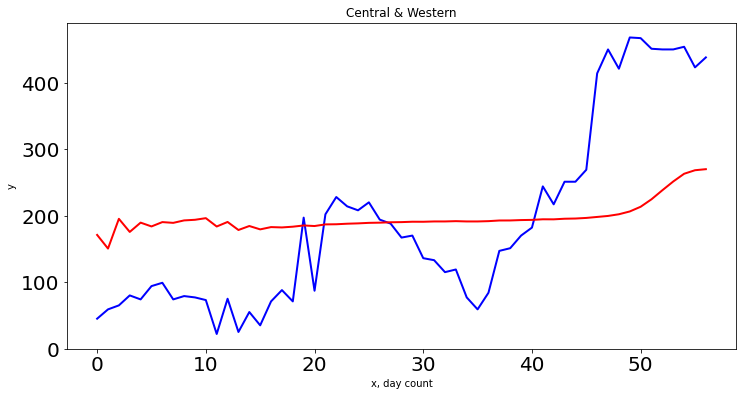

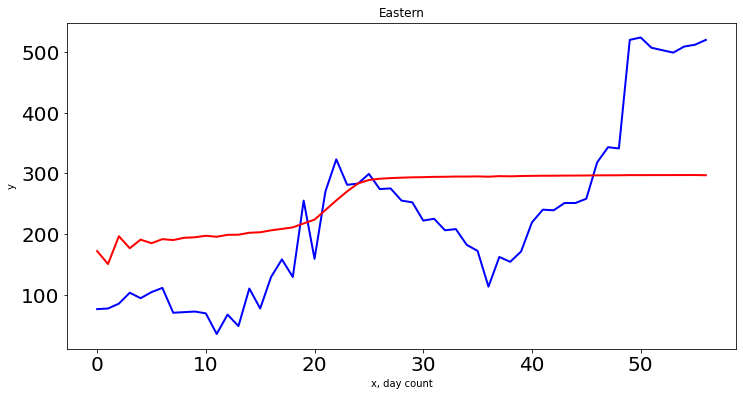

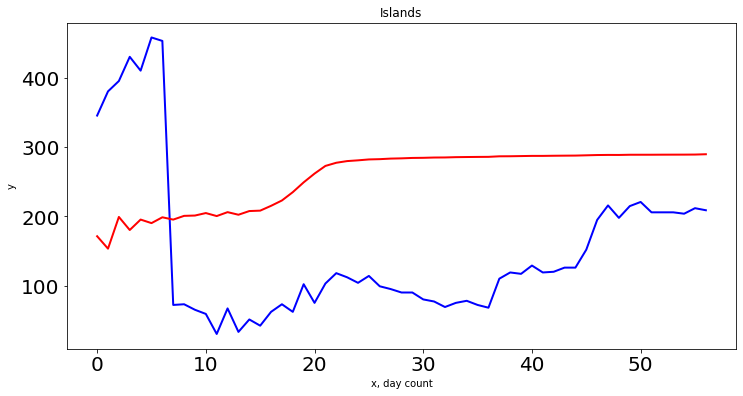

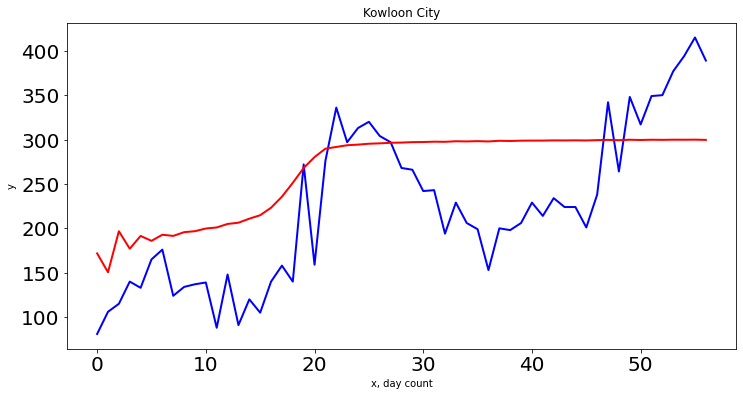

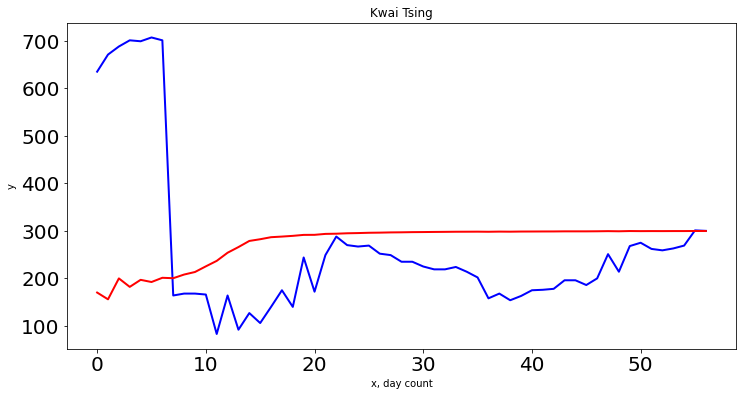

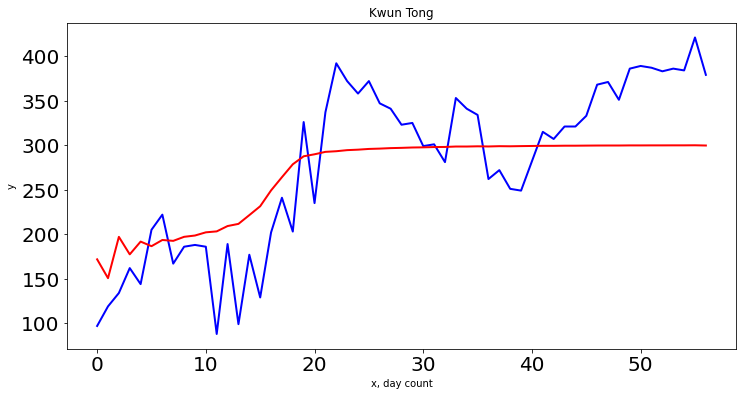

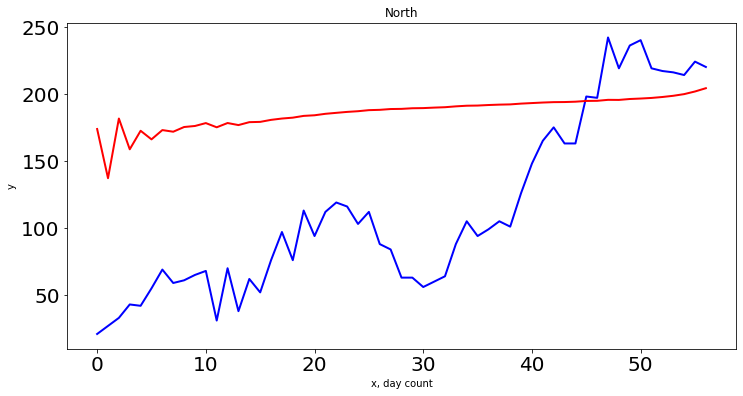

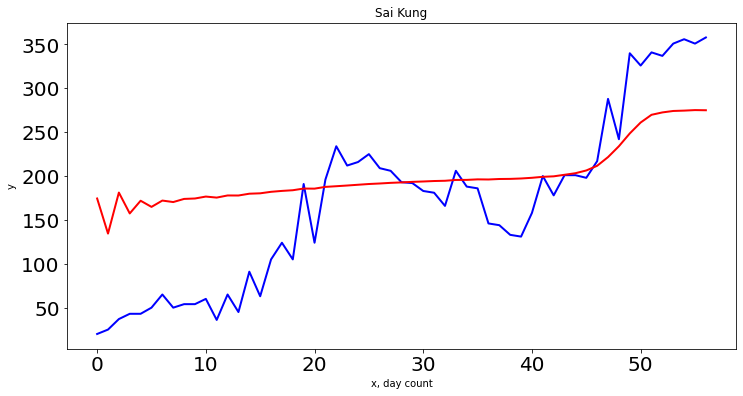

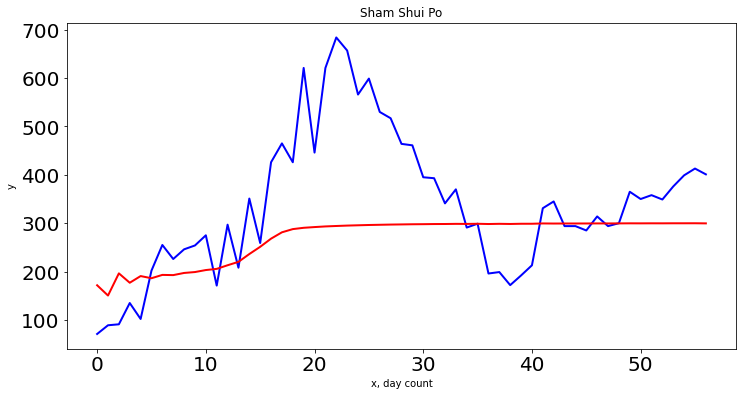

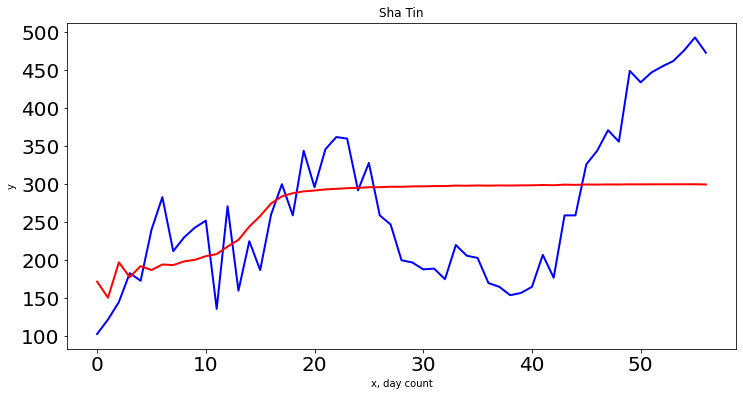

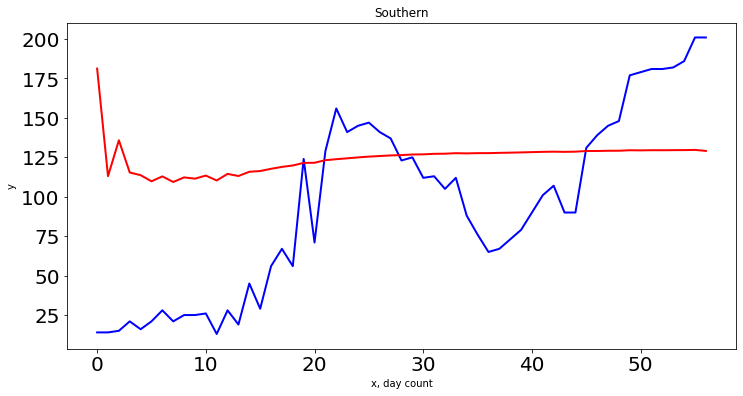

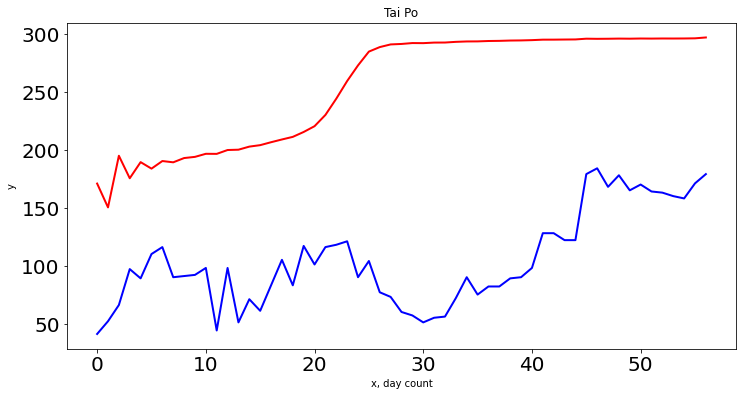

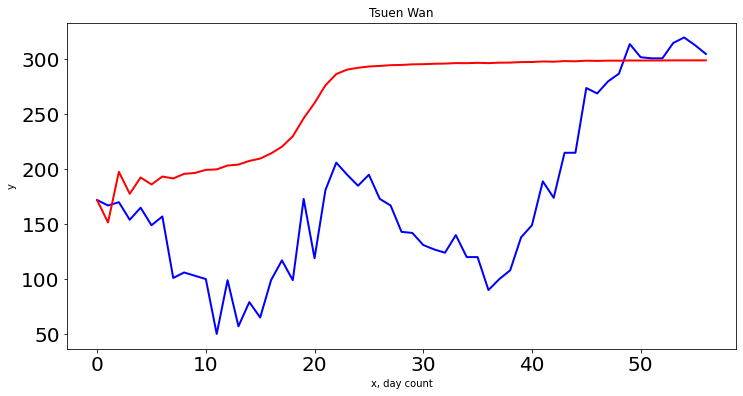

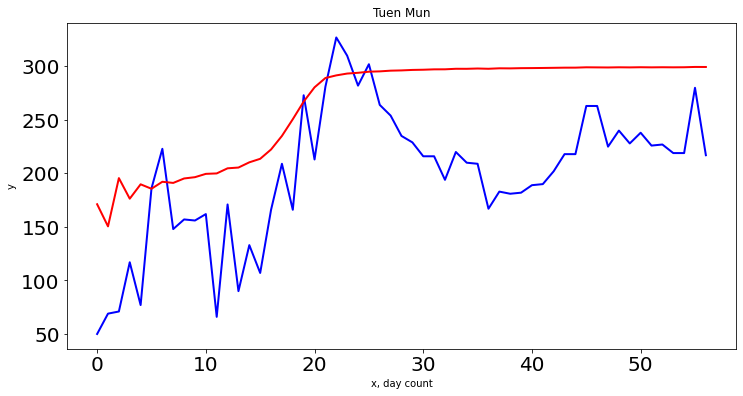

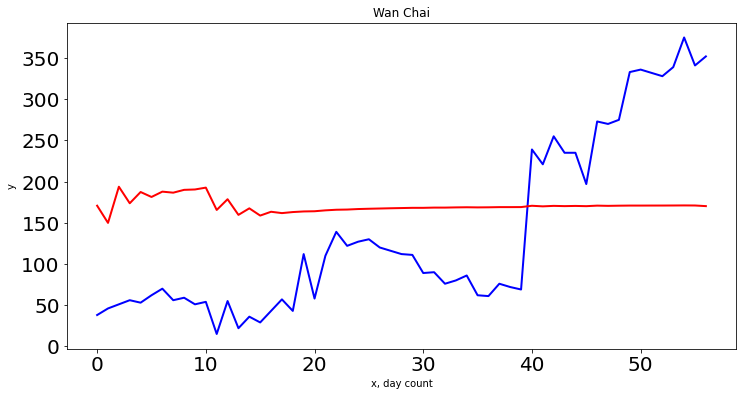

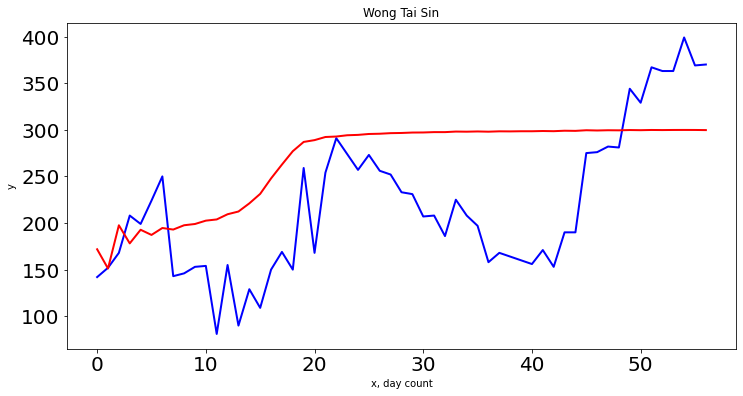

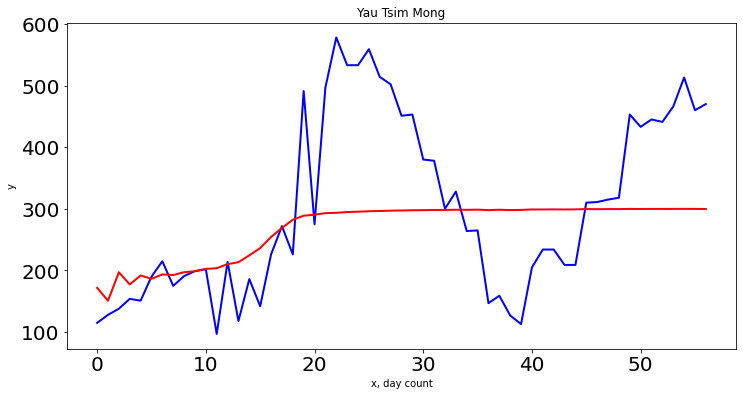

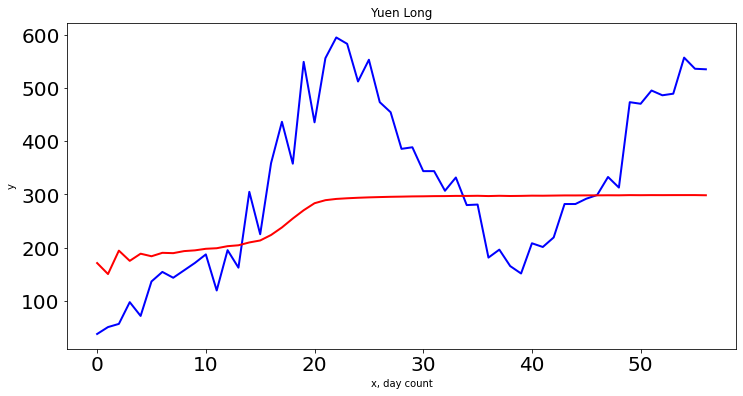

In [ ]:
pred_districts = []
predictions = []
value = np.array(district_series).astype(np.float32)

for j in range(18):
  test_input = torch.from_numpy(value[j:j+1, :-1]) # 3, 56
  test_target = torch.from_numpy(value[j:j+1, :]) # 3, 57  
  with torch.no_grad():
    future = 1 # future = 1000
    pred = model(test_input, future=future)
    # print("test target shape is ", test_target.shape)
    loss = criterion(pred, test_target)
    # print("pred shape is ", pred[:, :-future].shape)
    print("test loss", loss.item())
    y = pred.detach().numpy()
  
  plt.figure(figsize=(12,6))
  plt.title(districts[j])
  plt.xlabel("x, day count")
  plt.ylabel("y")
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  n = test_target.shape[1]
  def draw(y_i, color):
    plt.plot(np.arange(n), test_target[0], 'b', linewidth=2.0) # actual values
    plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0) # predicted values
    # plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0) # predicted values
  draw(y[0], 'r')
  #SMAPE Equation
  pred_districts.append(np.sum(2*np.abs(np.array(y[0])-np.array(test_target))/(np.abs(np.array(test_target))+np.abs(np.array(y[0]))))/18)

In [ ]:
# for i in range(len(models)):
#   torch.save(models[i].state_dict(), f"/content/drive/MyDrive/COMP 4222/lstm_covid/{districts[i]}_model")

In [ ]:
models = [LSTMPredictor()] * 18
# models = []
for i in range(18):
  models[i].load_state_dict(torch.load(f"/content/drive/MyDrive/COMP 4222/lstm_covid/{districts[i]}_model"))

In [ ]:
# print(models[1])

test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34
test loss 2.4269027140324895e+34


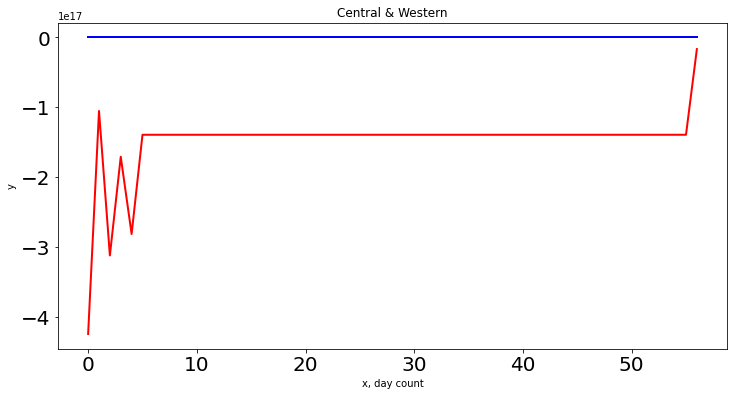

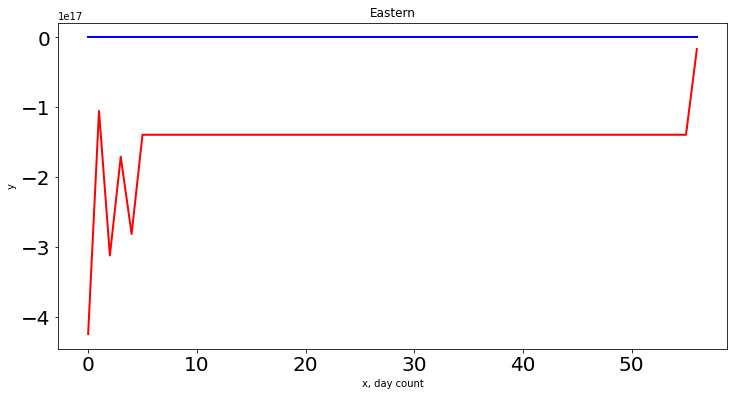

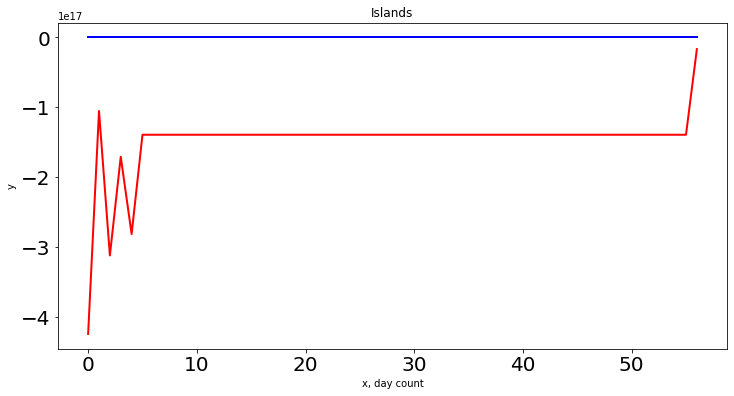

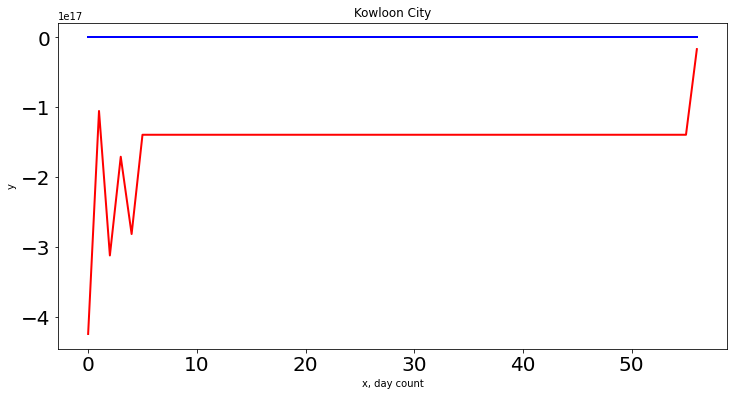

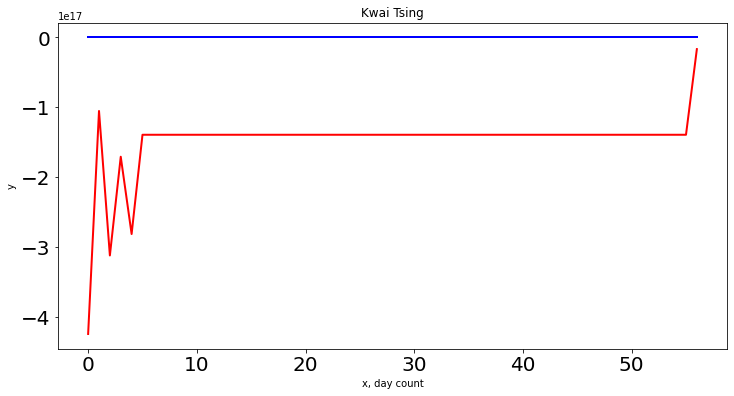

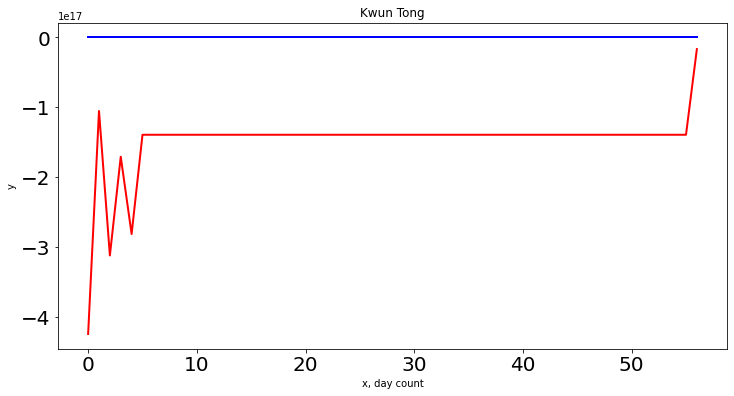

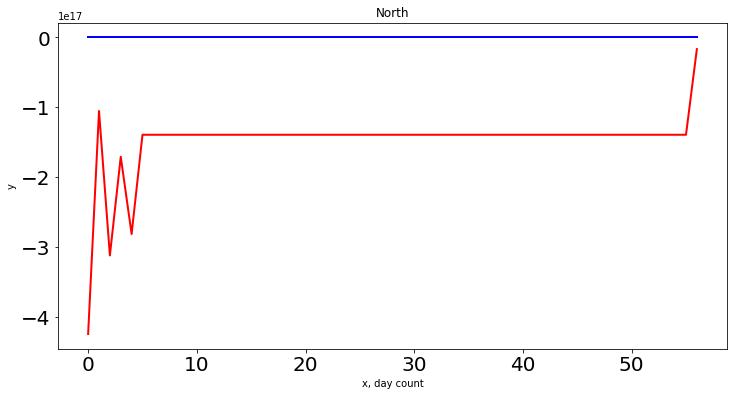

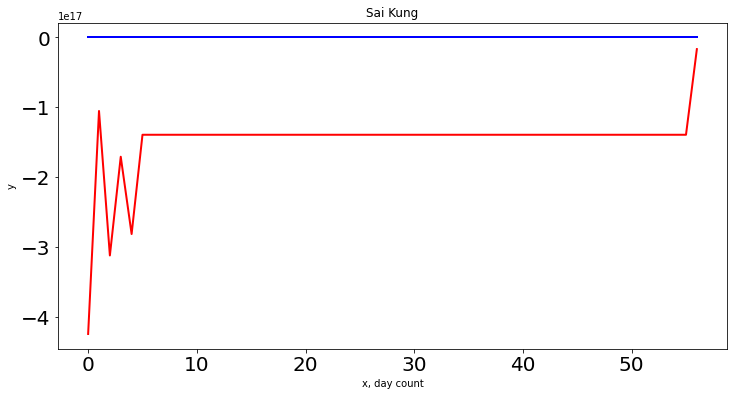

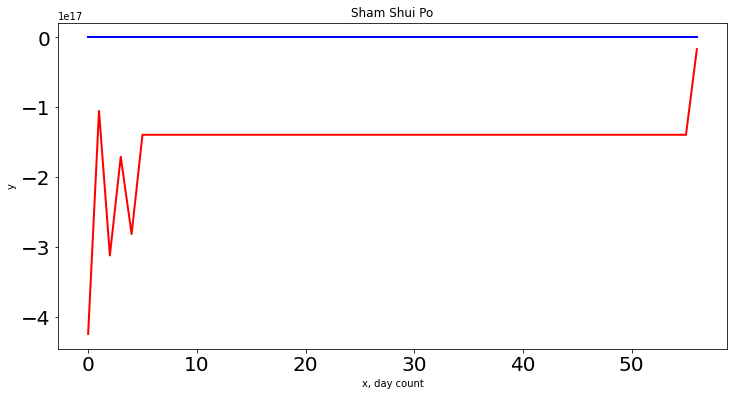

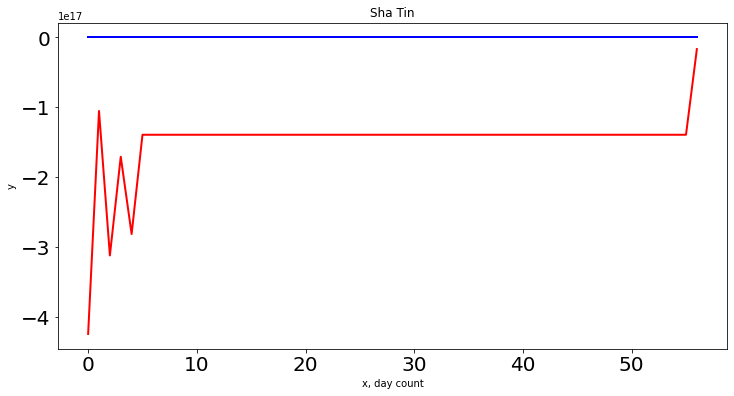

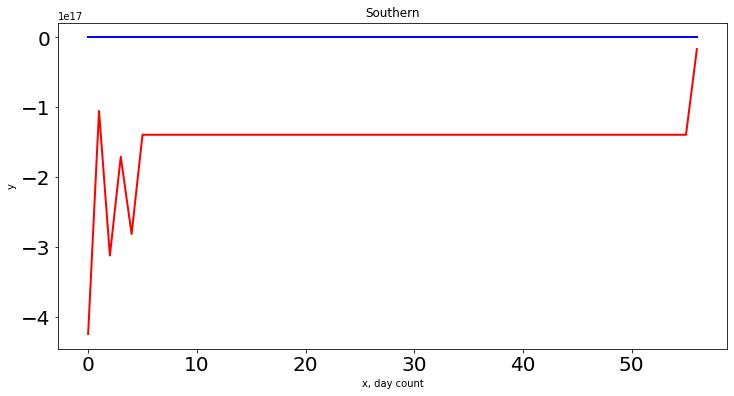

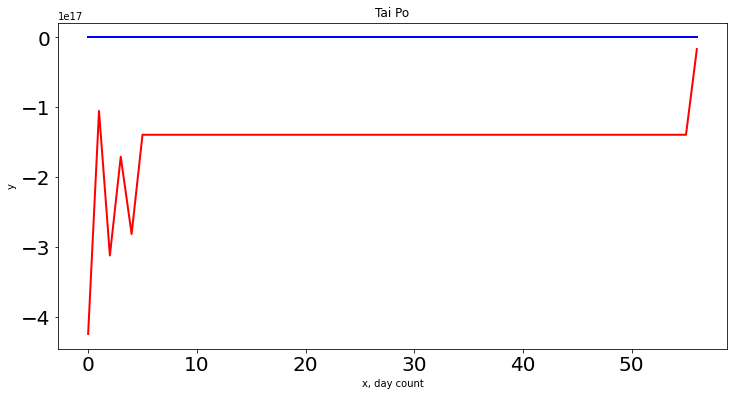

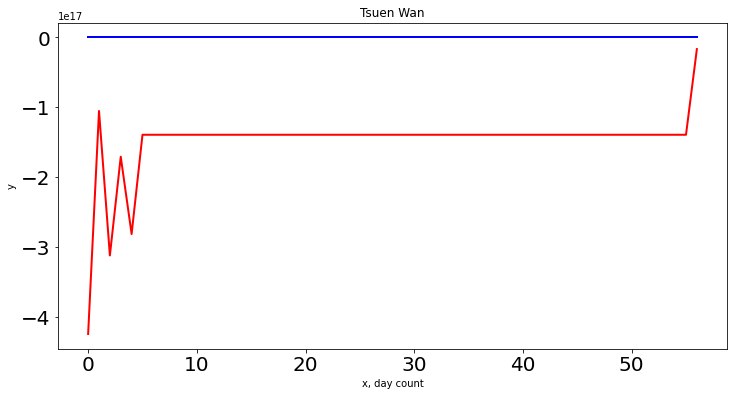

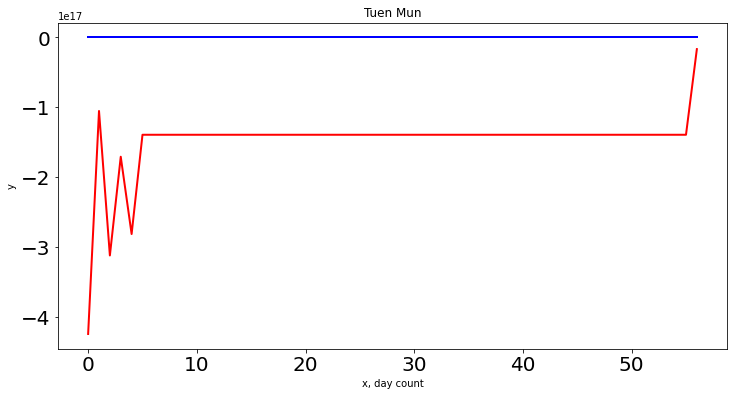

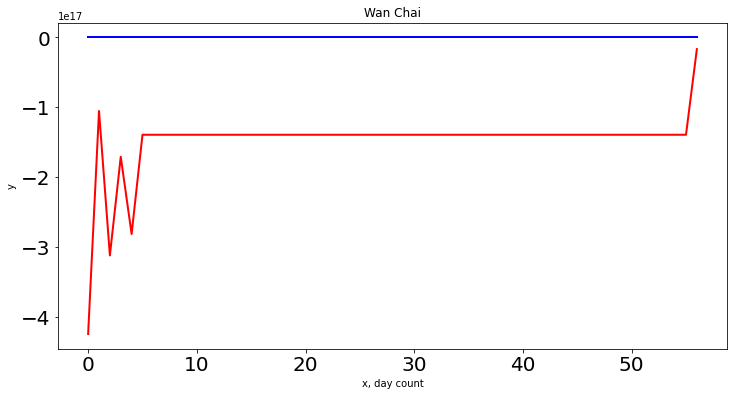

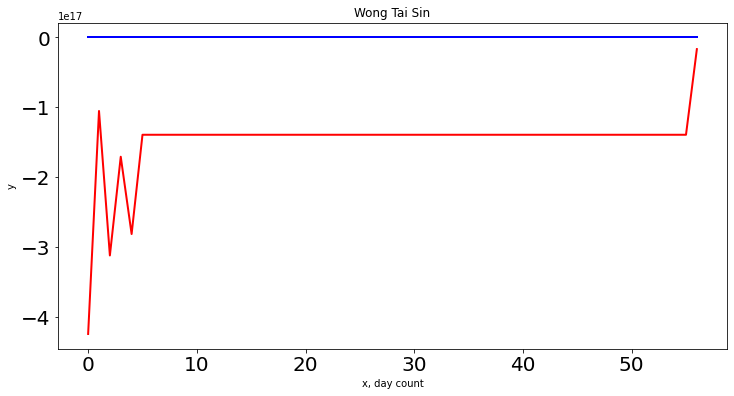

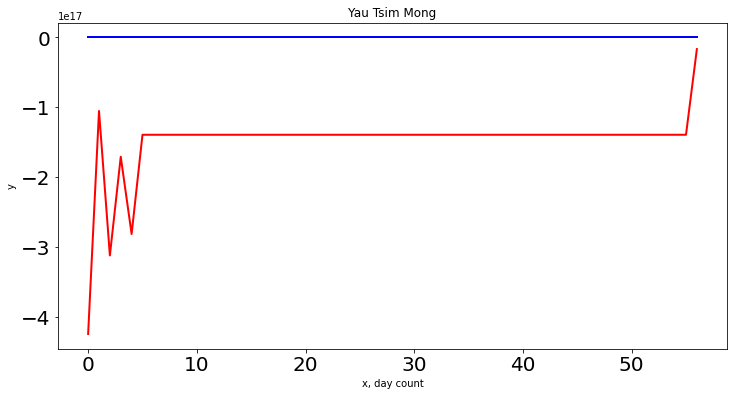

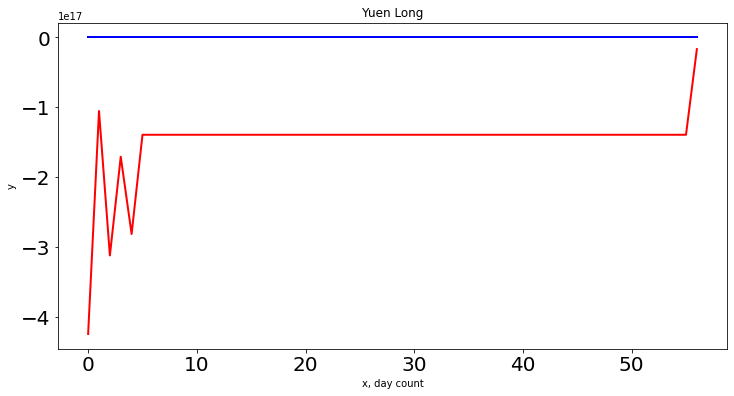

In [ ]:
pred_districts = []
predictions = []
value = np.array(district_series).astype(np.float32)

for j in range(18):
  model = models[j]
  test_input = torch.from_numpy(value[j:j+1, :-1]) # 3, 56
  test_target = torch.from_numpy(value[j:j+1, :]) # 3, 57  
  with torch.no_grad():
    future = 1 # future = 1000
    pred = model(test_input, future=future)
    # print("test target shape is ", test_target.shape)
    loss = criterion(pred, test_target)
    # print("pred shape is ", pred[:, :-future].shape)
    print("test loss", loss.item())
    y = pred.detach().numpy()
  
  plt.figure(figsize=(12,6))
  plt.title(districts[j])
  plt.xlabel("x, day count")
  plt.ylabel("y")
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  n = test_target.shape[1]
  def draw(y_i, color):
    plt.plot(np.arange(n), test_target[0], 'b', linewidth=2.0) # actual values
    plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0) # predicted values
    # plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0) # predicted values
  draw(y[0], 'r')

  # pred_districts.append(np.corrcoef(y[0], test_target)[0,1])
  # predictions.append()
  #SMAPE Equation
  pred_districts.append(np.sum(2*np.abs(np.array(y[0])-np.array(test_target))/(np.abs(np.array(test_target))+np.abs(np.array(y[0]))))/18)

In [ ]:
pred_districts = np.array(pred_districts)
print(pred_districts)

[6.33333333 6.33333333 6.33333333 6.33333333 6.33333333 6.33333333
 6.33333333 6.33333333 6.33333333 6.33333333 6.33333333 6.33333333
 6.33333333 6.33333333 6.33333333 6.33333333 6.33333333 6.33333333]


test Apr1 to may31

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch

test_csv_pds = []
test_dates = []
for file in os.listdir("/content/drive/MyDrive/COMP 4222/data_Apr1_May31"):
    if file.endswith(".csv"):
        # print(file)
        test_csv_pds.append(pd.read_csv("/content/drive/MyDrive/COMP 4222/data_Apr1_May31/"+file,on_bad_lines="skip"))
        test_dates.append(file[0:8])



from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

districts = ['Central & Western', 'Eastern', 'Islands', 'Kowloon City', 'Kwai Tsing',
 'Kwun Tong', 'North', 'Sai Kung', 'Sham Shui Po', 'Sha Tin', 'Southern',
 'Tai Po', 'Tsuen Wan', 'Tuen Mun', 'Wan Chai', 'Wong Tai Sin', 'Yau Tsim Mong',
 'Yuen Long']

iter =0
for csv in test_csv_pds:
  csv["District"] = csv.apply(lambda row: districts[np.argmax(np.array([similar(row["District"],key) for key in districts]))], axis=1)
  count = csv['District'].unique()
  iter += 1
  if len(count) != 18:
    print("failed entry recorded") 
  print(iter)
  

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [ ]:
test_series_count_district ={}
for district in districts:
    test_series_count_district[district] = []
print(series_count_district)



day =0
for pd in test_csv_pds:
    for district in districts:
          test_series_count_district[district].append((pd['District'] == district).sum())
print(test_series_count_district)

{'Central & Western': [45, 59, 65, 80, 74, 94, 99, 74, 79, 77, 73, 22, 75, 25, 55, 35, 71, 88, 71, 197, 87, 202, 228, 214, 208, 220, 194, 188, 167, 170, 136, 133, 115, 119, 77, 59, 84, 147, 151, 170, 182, 244, 217, 251, 251, 269, 414, 450, 421, 468, 467, 451, 450, 450, 454, 423, 438], 'Eastern': [76, 77, 85, 103, 94, 104, 111, 70, 71, 72, 69, 35, 67, 48, 110, 77, 129, 158, 129, 255, 159, 270, 323, 281, 283, 299, 274, 275, 255, 252, 222, 225, 206, 208, 182, 172, 113, 162, 154, 171, 219, 240, 239, 251, 251, 258, 318, 343, 341, 520, 524, 507, 503, 499, 509, 512, 520], 'Islands': [346, 381, 396, 431, 411, 459, 454, 72, 73, 65, 59, 30, 67, 33, 51, 42, 62, 73, 62, 102, 75, 103, 118, 112, 104, 114, 99, 95, 90, 90, 80, 77, 69, 75, 78, 72, 68, 110, 119, 117, 129, 119, 120, 126, 126, 152, 195, 216, 198, 215, 221, 206, 206, 206, 204, 212, 209], 'Kowloon City': [81, 106, 115, 140, 133, 165, 176, 124, 134, 137, 139, 88, 148, 91, 120, 105, 140, 158, 140, 272, 159, 276, 336, 297, 313, 320, 304, 297, 

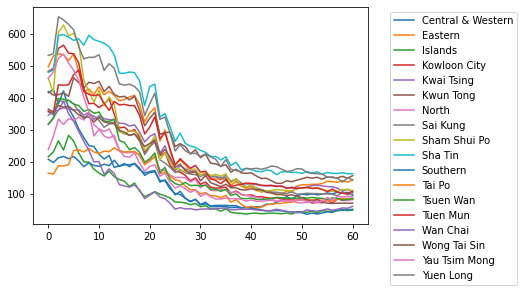

In [ ]:

#plot the series_count_district data
for district in test_series_count_district:
    # if(district == "Wong Tai Sin"):
    plt.plot(test_series_count_district[district], label=district)
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()



In [ ]:
test_district_series = []
for district in districts:
  test_district_series.append(test_series_count_district[district])

test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34
test loss 2.394670469229616e+34


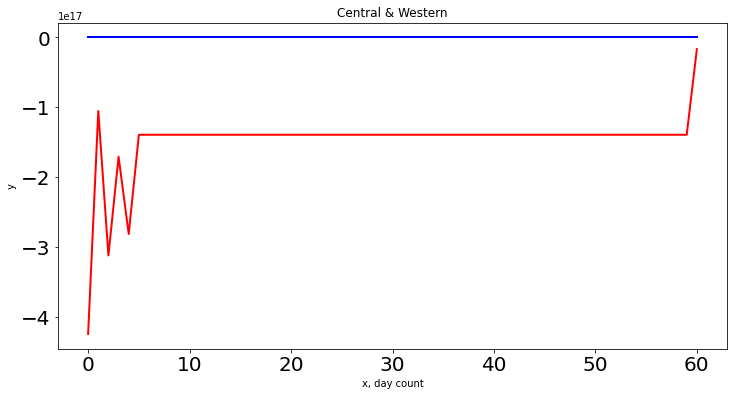

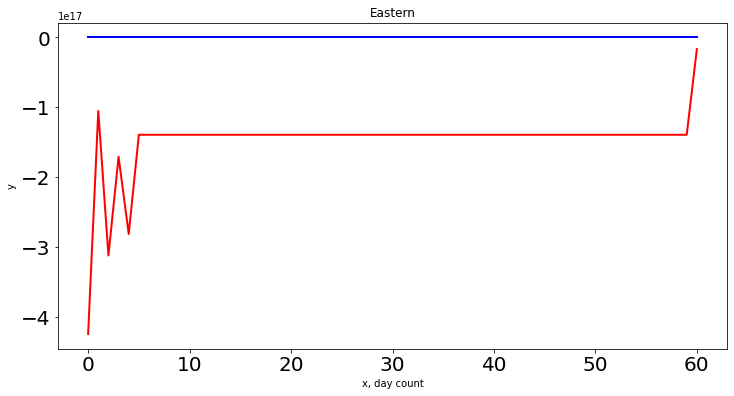

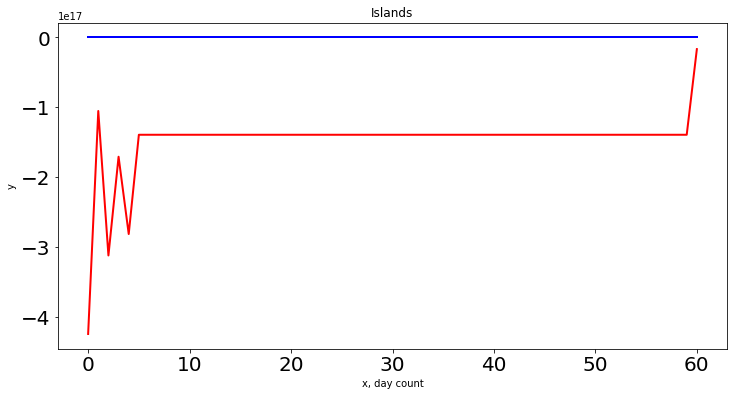

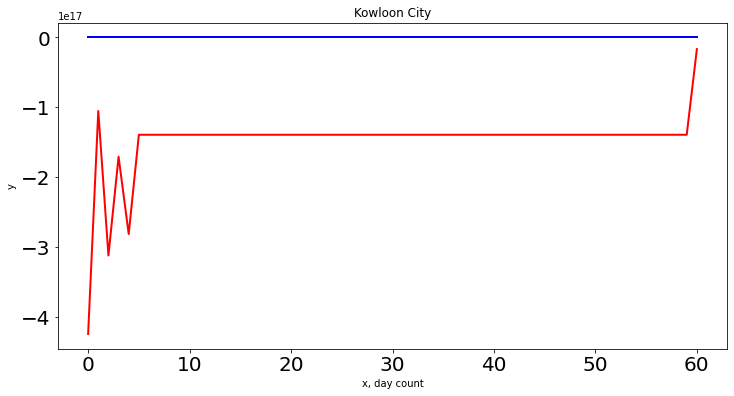

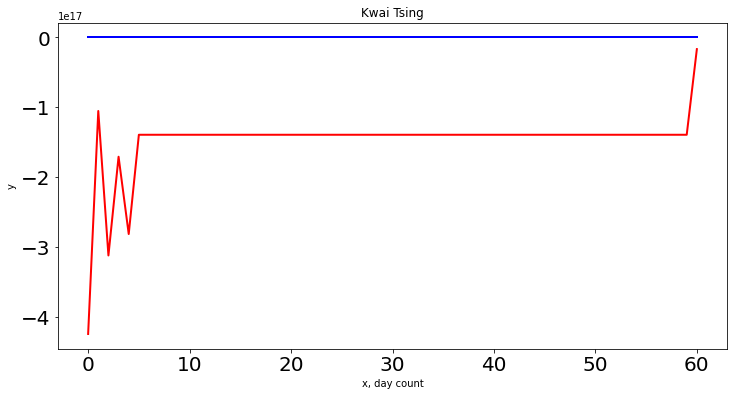

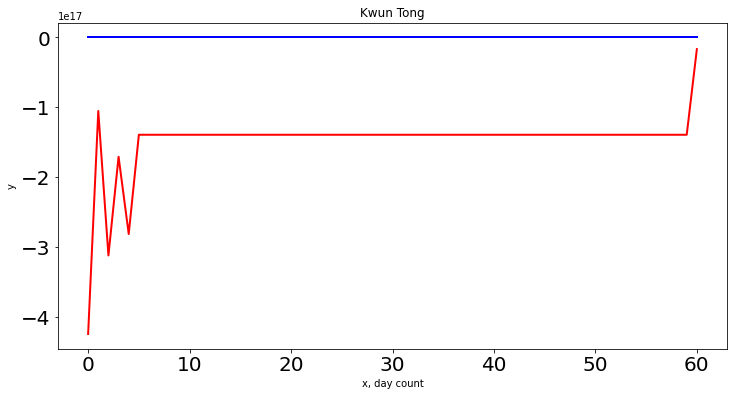

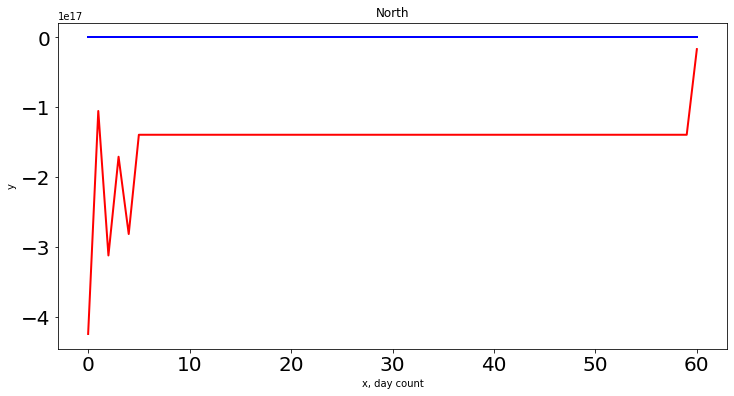

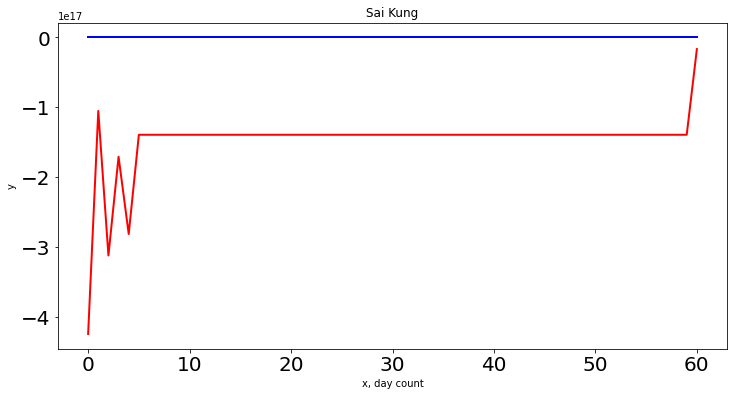

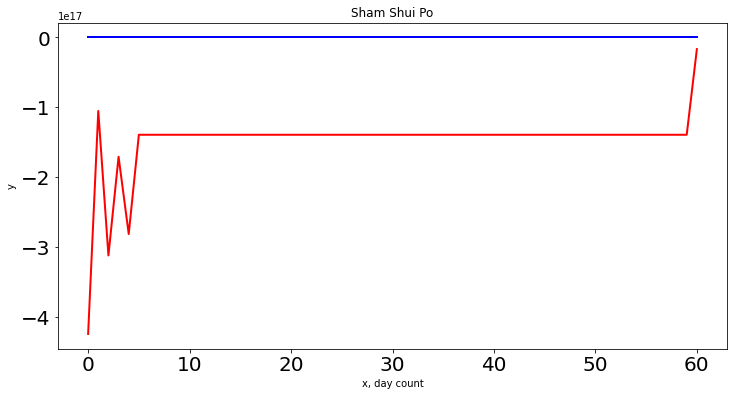

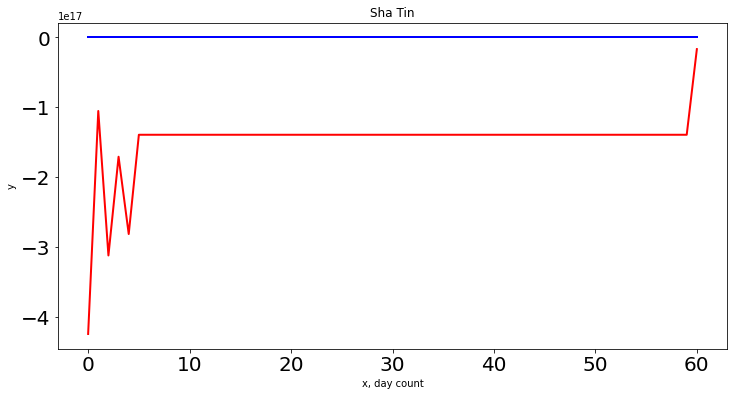

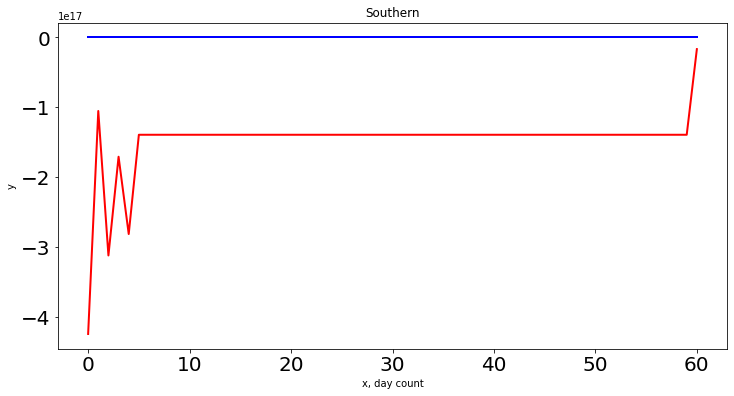

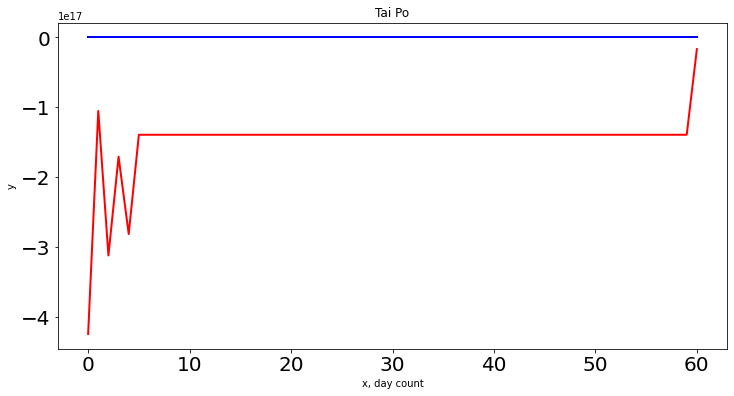

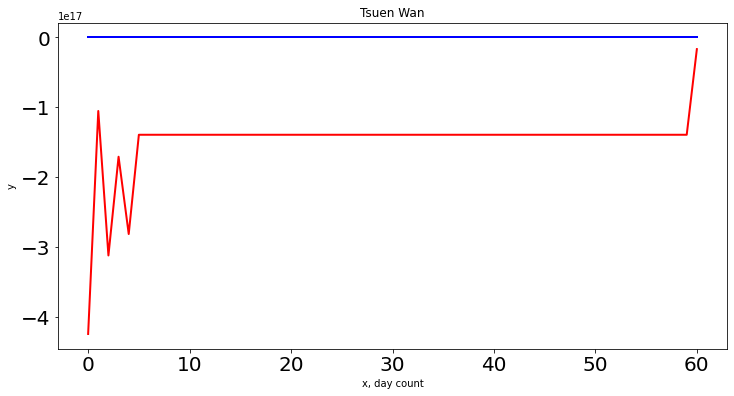

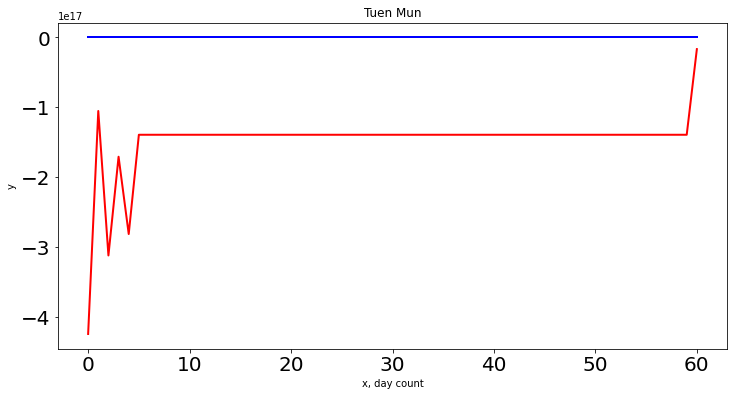

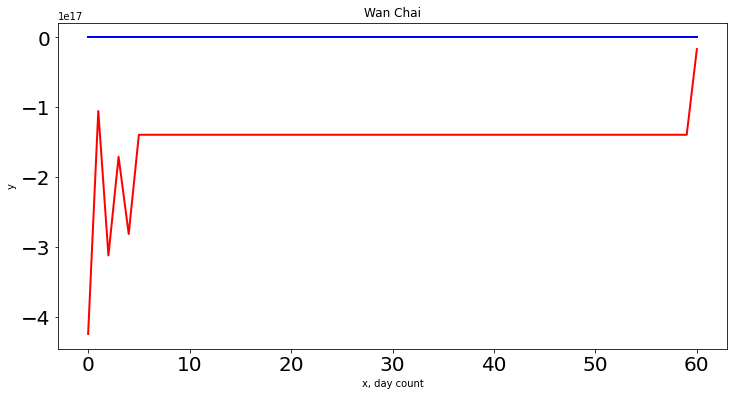

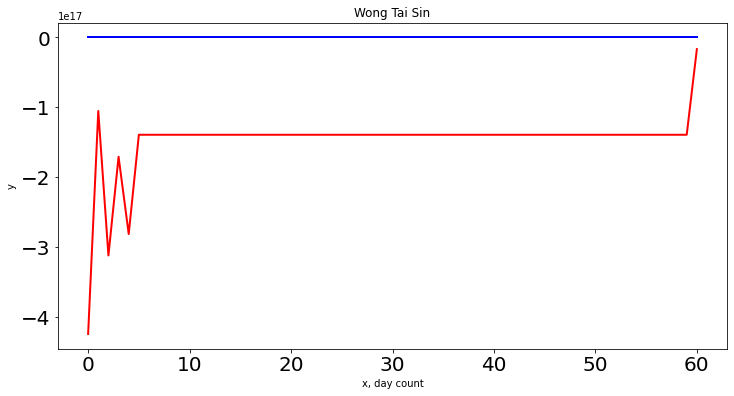

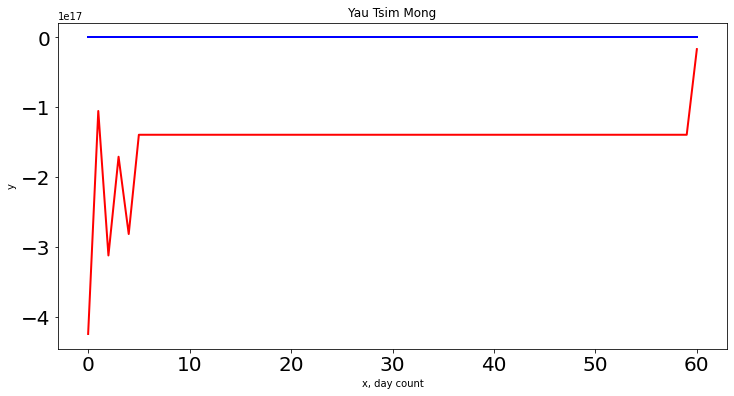

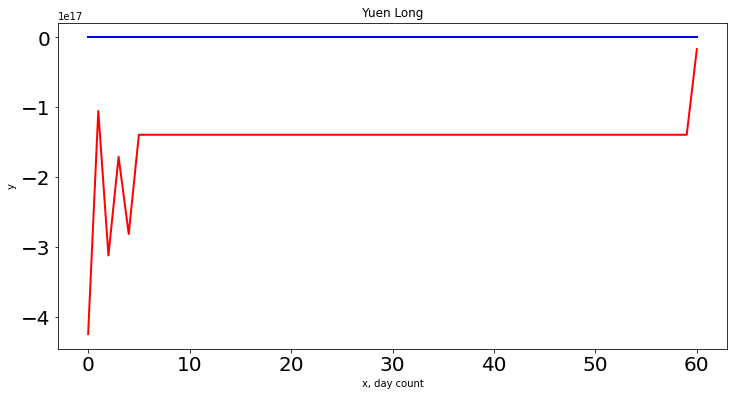

In [ ]:
test_pred_districts = []
value = np.array(test_district_series).astype(np.float32)

for j in range(18):
  model = models[j]
  test_input = torch.from_numpy(value[j:j+1, :-1]) # 3, 56
  test_target = torch.from_numpy(value[j:j+1, :]) # 3, 57  
  with torch.no_grad():
    future = 1 # future = 1000
    pred = model(test_input, future=future)
    # print("test target shape is ", test_target.shape)
    loss = criterion(pred, test_target)
    # print("pred shape is ", pred[:, :-future].shape)
    print("test loss", loss.item())
    y = pred.detach().numpy()
  
  plt.figure(figsize=(12,6))
  plt.title(districts[j])
  plt.xlabel("x, day count")
  plt.ylabel("y")
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  n = test_target.shape[1]
  def draw(y_i, color):
    plt.plot(np.arange(n), test_target[0], 'b', linewidth=2.0) # actual values
    plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0) # predicted values
    # plt.plot(np.arange(n, n+future), y_i[n:], color + ":", linewidth=2.0) # predicted values
  draw(y[0], 'r')

  # pred_districts.append(np.corrcoef(y[0], test_target)[0,1])
  # predictions.append()
  #SMAPE Equation
  test_pred_districts.append(np.sum(2*np.abs(np.array(y[0])-np.array(test_target))/(np.abs(np.array(test_target))+np.abs(np.array(y[0]))))/18)

In [ ]:
print(np.array(test_pred_districts)) # predictions (error rate)

[6.77777778 6.77777778 6.77777778 6.77777778 6.77777778 6.77777778
 6.77777778 6.77777778 6.77777778 6.77777778 6.77777778 6.77777778
 6.77777778 6.77777778 6.77777778 6.77777778 6.77777778 6.77777778]
